# CopyCat: Example Usage on Terabyte Runs

This notebook assumes that you have a jupyter notebook with CopyCat installed.
To start a jupyter notebook with CopyCat installed and your local directory mounted, run:
```
docker run --rm -ti -v ${PWD}:/home/jovyan -p 8888:8888 webis/chatnoir-copycat:1.0-jupyter
```


Then, we use the CopyCat cli to deduplicate run files submitted to Terabyte 2006.

## Step 1: Build the Index of the GOV2 corpus with Anserini

You need:
- a copy of the [GOV2 collection](http://ir.dcs.gla.ac.uk/test_collections/access_to_data.html)
  - The variable `PATH_TO_GOV2` should point to the GOV2 collection. I.e., `!du -h -s $PATH_TO_GOV2` should show 81G and `!ls $PATH_TO_GOV2` should list files `GX000` to `GX272`.
- run files submitted to the [TREC 2006 Terabyte track](https://trec.nist.gov/results/trec15/terabyte-adhoc.input.html)
  - The variable `PATH_TO_RUNS` should contain all run files submitted to Terabyte 2006. I.e., `!du -h -s $PATH_TO_RUNS` should show 1.1G and `!ls $PATH_TO_RUNS` should list files `input.AMRIMtp20006.gz` to `input.zetamerg.gz`.

We use [Anserini](https://github.com/castorini/anserini/blob/master/docs/regressions-gov2.md) to index the GOV2 collection to deduplicate the run files (to speed up the index creation, we index only documents that are in the run files).

In [1]:
# variables as discussed above
PATH_TO_GOV2='/mnt/ceph/storage/corpora/corpora-thirdparty/corpora-trec/corpus-trec-web/DOTGOV2/gov2-corpus'
PATH_TO_RUNS='terabyte-data'

# create list of ids to deduplicate
from trectools import TrecRun
RUNS = !ls $PATH_TO_RUNS

for run in RUNS:
    print('Process: ' + run)
    r = TrecRun(PATH_TO_RUNS + '/' + run)
    r.run_data = r.run_data[r.run_data['rank'] <= 50]
    if len(r.run_data) < 8000:
        r.run_data.to_csv('terabyte-runs-top50/' + r.get_runid(), sep='\t', index=False, header=False)
PATH_TO_RUNS = 'terabyte-runs-top50/'
RUNS = !ls $PATH_TO_RUNS

!cat terabyte-runs-top50/*|awk '{print $4}'|sort -u > terabyte-runs-top50/allow-list

Process: input.AMRIMtp20006.gz
Process: input.AMRIMtp5006.gz
Process: input.AMRIMtpm5006.gz
Process: input.arscDomAlog.gz
Process: input.arscDomAsrt.gz
Process: input.arscDomManL.gz
Process: input.arscDomManS.gz
Process: input.CoveoRun1.gz
Process: input.CWI06DISK1ah.gz
Process: input.CWI06DIST8ah.gz
Process: input.DCU05BASE.gz
Process: input.hedge0.gz
Process: input.hedge10.gz
Process: input.hedge30.gz
Process: input.hedge50.gz
Process: input.hedge5.gz
Process: input.humT06l.gz
Process: input.humT06xlc.gz
Process: input.humT06xle.gz
Process: input.humT06xl.gz
Process: input.humT06xlz.gz
Process: input.indri06AdmD.gz
Process: input.indri06AlceB.gz
Process: input.indri06AlceD.gz
Process: input.indri06Aql.gz
Process: input.indri06AtdnD.gz
Process: input.JuruMan.gz
Process: input.JuruTD.gz
Process: input.JuruT.gz
Process: input.JuruTWE.gz
Process: input.mg4jAdhocBBV.gz
Process: input.mg4jAdhocBV.gz
Process: input.mg4jAdhocBVV.gz
Process: input.mg4jAdhocV.gz
Process: input.mg4jAutoBBV.gz
P

In [2]:
# navigate to your Anserini installation to index the GOV2 corpus with the following command
GOV2_INDEX='lucene-index.gov2.pos+docvectors+raw'

!target/appassembler/bin/IndexCollection -collection TrecwebCollection \
    -input $PATH_TO_GOV2 \
    -index lucene-index.gov2.pos+docvectors+raw \
    -whitelist allow-list\
    -generator JsoupGenerator \
    -threads 5 -storePositions -storeDocvectors -storeRawDocs

# Step 2: Verify the Download; Double Check the Document Preprocessing

We have double-checked the preprocessing for the ClueWebs and CommonCrawls by many unit and integration tests.
Since the GOV2 dataset is not included in these tests, we have to double-check the preprocessing using some examples. (Please [see here](https://github.com/chatnoir-eu/copycat/blob/master/copycat-modules/document-preprocessing/README.md) for an overview of preprocessing options.)

To verify the preprocessing, we check a few documents manually.

In [6]:
# Use CopyCat to check the preprocessing for a single document

!copy-cat \
    --retrieveDocId GX272-84-11390548 \
    --documents AnseriniIndex \
    --anseriniIndex $GOV2_INDEX \
    --keepStopwords False \
    --output a --input a

januari 1 2003 honor governor georg h ryan state hou room 207 springfield illinoi 62706 honor governor ryan i am plea submit report behalf illinoi deaf hard hear commiss activ calendar year 2002 deaf hard hear commiss execut agenc state dedic advoc public polici regul program design improv qualiti coordin exist servic individu hear loss well promot new servic whenev necessari respon assess need deaf hard hear commiss serv conduit inform deaf hard hear commun gener public legisl govern agenc servic provid organ privat entiti deaf hard hear commiss empow deaf hard hear individu affirm indisput right equal respect independ self suffici ncy access societi commiss structur membership eleven initi member deaf hard hear commiss were appoint novemb 1997 stagger four year term time write four member term have expir two member have resign result six vacanc requir reappoint replac staf commiss staf eight posit seven which current fill vacanc exist which ha en fill due administr order number 1 see

The preprocessed GOV2 document GX272-84-11390548 looks good (stemming as expected, no problems with encoding, etc.).

## Step 3: Deduplicate all run files submitted to the TREC Terabyte 2006 Tracks

Now that we have double-checked that the document preprocessing works as expected for Terabyte 2006, we can deduplicate the run files and inspect the results.

In [4]:
# this helper function executes copycat on the passed run file with the double-checked document preprocessing
def deduplicate_run_file(run_name, ranks):
    input_file = PATH_TO_RUNS + '/' + run_name
    output_file = PATH_TO_RUNS + 'deduplication/' + run_name + 'deduplication-top' + str(ranks) + '.jsonl'
    
    !copy-cat \
        --output $output_file \
        --input  $input_file \
        --similarities "s3" \
        --s3Threshold 0.8 \
        --threads 10 \
        --ranks $ranks \
        --documents AnseriniIndex \
        --keepStopwords True \
        --anseriniIndex $GOV2_INDEX

# Preprocess all runs
RUNS = !ls $PATH_TO_RUNS|grep -v allow
for run in RUNS:
    print('Process: ' + run)
    for depth in [10, 50]:
        deduplicate_run_file(run, depth)

Process: AMRIMtp20006
The specified output 'terabyte-runs-top50/deduplication/AMRIMtp20006deduplication-top10.jsonl' exists.
Skip...
Process: AMRIMtp5006
The specified output 'terabyte-runs-top50/deduplication/AMRIMtp5006deduplication-top10.jsonl' exists.
Skip...
Process: AMRIMtpm5006
The specified output 'terabyte-runs-top50/deduplication/AMRIMtpm5006deduplication-top10.jsonl' exists.
Skip...
Process: arscDomAlog
The specified output 'terabyte-runs-top50/deduplication/arscDomAlogdeduplication-top10.jsonl' exists.
Skip...
Process: arscDomAsrt
The specified output 'terabyte-runs-top50/deduplication/arscDomAsrtdeduplication-top10.jsonl' exists.
Skip...
Process: arscDomManL
The specified output 'terabyte-runs-top50/deduplication/arscDomManLdeduplication-top10.jsonl' exists.
Skip...
Process: arscDomManS
The specified output 'terabyte-runs-top50/deduplication/arscDomManSdeduplication-top10.jsonl' exists.
Skip...
Process: CoveoRun1
The specified output 'terabyte-runs-top50/deduplication/Cove

Process: UAmsT06a3SUM
The specified output 'terabyte-runs-top50/deduplication/UAmsT06a3SUMdeduplication-top10.jsonl' exists.
Skip...
Process: UAmsT06aAnLM
The specified output 'terabyte-runs-top50/deduplication/UAmsT06aAnLMdeduplication-top10.jsonl' exists.
Skip...
Process: UAmsT06aTDN
The specified output 'terabyte-runs-top50/deduplication/UAmsT06aTDNdeduplication-top10.jsonl' exists.
Skip...
Process: UAmsT06aTeLM
The specified output 'terabyte-runs-top50/deduplication/UAmsT06aTeLMdeduplication-top10.jsonl' exists.
Skip...
Process: UAmsT06aTTDN
The specified output 'terabyte-runs-top50/deduplication/UAmsT06aTTDNdeduplication-top10.jsonl' exists.
Skip...
Process: uogTB06QET1
The specified output 'terabyte-runs-top50/deduplication/uogTB06QET1deduplication-top10.jsonl' exists.
Skip...
Process: uogTB06QET2
The specified output 'terabyte-runs-top50/deduplication/uogTB06QET2deduplication-top10.jsonl' exists.
Skip...
Process: uogTB06S50L
The specified output 'terabyte-runs-top50/deduplicatio

# Evaluate Redundancy

In [6]:
import json
import pandas as pd

def eval_with_threshold(threshold, run_file_name):
    rows = []
    with open(run_file_name) as jsonl_file:
        for jsonl in jsonl_file:
            dedup_data = json.loads(jsonl)
            docs_to_remove = []
            
            for sim in dedup_data['similarities']:
                if sim['similarities']['s3'] >=  threshold:
                    docs_to_remove += [sim['secondId']]

                
            rows += [{
                    'topic': dedup_data['topic'],
                    'duplicates': len(set(docs_to_remove)),
                    'docs': dedup_data['docs'],
                }]

    return rows

def eval_runs_with_threshold(threshold, run_files):
    rows = []
    for r in run_files:
        rows += eval_with_threshold(threshold, r)
    
    return pd.DataFrame(rows)

In [9]:
DEDUP_TARGET_DIR=PATH_TO_RUNS + 'deduplication/'
ALL_DIRS=!ls $DEDUP_TARGET_DIR
ALL_DIRS = [DEDUP_TARGET_DIR + i for i in ALL_DIRS if '.jsonl' in i]

df = eval_runs_with_threshold(0.82, ALL_DIRS)
df = df[df['docs'] > 9]
df['redundancy'] = df['duplicates']/df['docs']
df['docs'] = 10

In [10]:
df[['docs', 'redundancy']].groupby('docs').mean()

,redundancy
docs,
10,0.126488


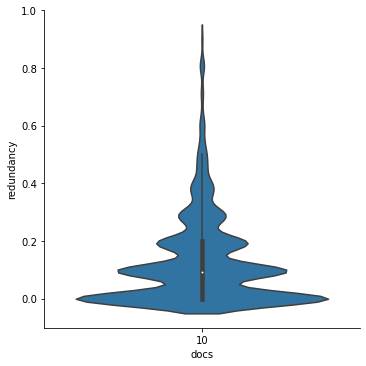

In [16]:
import seaborn as sns
sns.catplot(data=df, x='docs', y='redundancy', kind='violin', hue='docs')